# **A Baseline Model For Cluster Embeddings**

This notebook contains the ArcFace model for cluster embeddings. This uses a simple convolutional model to transform images into an embeddings space of length N. These embeddings are trained using the ArcMarginProduct and taking sending them into a classification loss. This will train the model to produce meaningful embeddings, resulting in good classification scores.

## **Notebook Overview**

A quick overview here will go over some of the results of ArcFace. We see some interesting things here, that really tie into our understanding of how the loss function works. For more detail on that please see the modelling section.

The first thing that sticks out to me is that the arc margin product is an effective way to generate decent embeddings that are separated along the different angles of the embedding space. The learned embeddings are in a tighter space than some of the other methods, this is likely because we only care about angles here and not really the absolute values of the embedding vectors. 

The second more important factor is that if we consider the embeddings to be ellipsoids around some centroid, we see that the long sides of the ellipsoid tend to allign more directly. This makes sense, but when we look at the theta-theata plot between clusters we see that the embeddings will have more uncertainty in the direction away from the nearest cluster. This makes intuitive sense with what we saw about how ArcFace works, with a constant angular margin among points to create a decision boundary.

## **Table of Contents**

1. [Imports & Setup](#Imports-&-Setup)
2. [Model Creation](#Model-Creation)
3. [Training](#Training)
4. [Clustering Embeddings Analysis](#Clustering-Embeddings-Analysis)
5. [Volume Of Embeddings Space](#Volume-Of-Embeddings-Space)
6. [Collect Cluster Info And Plot Mahalanbois Distance](#Collect-Cluster-Info-And-Plot-Mahalanbois-Distance)
7. [Display The Percent Of Volume That Each Cluster Takes Up](#Display-The-Percent-Of-Volume-That-Each-Cluster-Takes-Up)
8. [Visualize The Angles Between Points And Clusters](#Visualize-The-Angles-Between-Points-And-Clusters)
9. [Visualize The Clustering Embeddings](#Visualize-The-Clustering-Embeddings)


## **Imports & Setup**

In [1]:
# Import the necesary packages
import os
import gc
import math
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams.update({'font.size':14})
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from scipy.spatial import ConvexHull
from scipy.spatial.distance import mahalanobis, euclidean

In [2]:
# This is done to limit the memory growth on the GPU
# I was having trouble with my GPU memory being filled so I capped the availible memory
# growth here.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16_384)])
    except RuntimeError as e:
        print(e)

### **Configuration Object**

This is the configuration object that holds the main parameters we will be using later in our program. If we run our code with Weights and Biases (WANDB) then it will be saved to the given run, allowing us to see the effect of different hyper-parameters.

In [3]:
config = {
    # Basic information
    "AUTHOR": "Kiernan",
    
    # Training params
    "LR": 0.001,
    "BATCH_SIZE": 64,
    "EPOCHS": 50,
    
    # Loss parameters
    "SCALE": 15,
    "MARGIN": 0.4,
    
    # Model params
    "CONV_LAYERS": 8,
    "FIRST_FILTERS": 32,
    "FIRST_KERNEL_SIZE": (5,5),
    "N_FILTERS": 16,
    "KERNEL_SIZE": (3,3),
    "DROPOUT": 0.2,
    "EMBEDDING_SIZE": 3,
}

### **Initialize WANDB**

Weights and Biases is a very useful machine learning pipelining tool. It can be super handy when it comes to tracking experiments. It is capable of tracking the loss over epochs, the best model, and the parameters used when training different models. All this information can then be used ot optimize the hyper parameters of a model.

In [4]:
RUN_WANDB = False
if(RUN_WANDB):
    import wandb
    from wandb.keras import WandbCallback
    from secrets import WANDB
    wandb.login(key=WANDB)
    run = wandb.init(project="deep-clustering-evaluation", entity="kmcguigan", group="base-model", config=config, job_type="train")

### **Loading Data**

We created the data ahead of time to make these experiments more reproducible.

In [5]:
with open('data/train.npy', mode='rb') as infile:
    X_train = np.load(infile, allow_pickle=True)
    y_train = np.load(infile, allow_pickle=True)

with open('data/val.npy', mode='rb') as infile:
    X_val = np.load(infile, allow_pickle=True)
    y_val = np.load(infile, allow_pickle=True)

with open('data/test.npy', mode='rb') as infile:
    X_test = np.load(infile, allow_pickle=True)
    y_test = np.load(infile, allow_pickle=True)
    
with open('data/viz.npy', mode='rb') as infile:
    X_viz = np.load(infile, allow_pickle=True)
    y_viz = np.load(infile, allow_pickle=True)

print(f"Train data shape: {X_train.shape} Val data shape: {X_val.shape} Test data shape: {X_test.shape}")

Train data shape: (50000, 28, 28, 1) Val data shape: (10000, 28, 28, 1) Test data shape: (10000, 28, 28, 1)


### **Load in the Labels**

This dataframe maps the labels to their corresponding names. For classification we want numeric labels going from 1...N where N is the number of classes we have. In certain scenarios (like on MNIST) the label matches the name, but for other datasets we would want to map the numeric label to the human understandable name we associate with each class.

In [6]:
labels_df = pd.read_csv('data/label_names.csv')
labels_df['label'] = labels_df['label'].astype(int)
labels_df

,label,name
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


## **Model Creation**

### **An Overview of ArcFace Loss**

The ArcMargin Loss attempts to create meaningful embeddings by pushing samples from the same classes to have the closer angular distances. What this means is that ArcFace doesn't stack embeddings in space (or tries not to) like a triplet loss might, this is becuase the angle of the embedding vector is what we look at, and not the absolute value or distance that vector represents.

On the surface the idea of pushing same class samples to have smaller angular distances is pretty simple, this could be done by getting embeddings of N-CLASSES length, l2-normalizing this vector (meaning that the vector now sits on the unit circle with length 1), and matrix multiplying this with a target one-hot vector of shape N-CLASSES. This dot product would result in; 

DOT( Normalized-Embeddings, Target-Vector )|| Normalized-Embeddings || * || Target-Vector || * Cos( theta )

Since the length of a one-hot vector is just 1 and the normalized embeddings are length 1 we get the cosine similarity between the embeddings and the target. This is great but for most angular methods we want to use a margin to force the embeddings into a tighter space. There are many different methods of adding a margin to the angular distance, but ArcFace attempts this by adding a margin to the angle within the cosine similarity. This attempts to get the model to have a consistent sized boundary between the theta values from one cluster to another, creating a linear relationship between the distance from a clusters point to that cluster and the distance from another clusters samples to this cluster. Better put we would say that as a point within a cluster gets further away from the centroid of the cluser (when considering the angular distance) other clusters samples must move equally far away to maintain that angular margin. This provides a very easy linear decision boundary when looking at the theta value, making this a useful loss function. 

The next thing that ArcFace does that is different from the above example is that it doesn't have fixed orthogonal (or linearly independent) target vectors. This is because to get meaningful embeddings, and not just learning to make the right prediction, we have to learn that certain classes might be closer to eachother in embeddings space than others. A car and a truck would likely be closer in embeddings space than a person and a truck. To do this ArcFace uses randomly initialized (or any chosen initialization method) weight matrix, which is of shape (embedding size, number of classes). I have two ways of thinking about this, so whichever sounds best take it. The first is a more vector spatial based approach and is that we learn vectors in space that correspond to different classes, and we then adjust the position of these class vectors, and the weights that generate the embeddings to push everything into their own clusters. The next is more matrix based, and says that we learn a weight matrix W which acts as a linear transformation capable of transforming vectors in embeddings space into a classification space (which would be this one-hot vector).

We can then apply a margin to the target vector of each samples positive class, and then use a softmax function into a categorical crossentropy (a softmax loss) to get our results.

### **Create Model Body**

The body of the model is a very simple convolutional architecture. After a number of convolutional layers we finish with global average pooling which takes the average of all the pixels in each channel, returning a vector of (Batch Size, Number of Chanels). This vector can now be considered the embedding vector, representing the components of the image.

In [7]:
def create_body(image_shape):
    inputs = tf.keras.layers.Input(shape=image_shape, name="images")
    
    def cov_block(layer_inputs, n_filters, kernel_size, strides=1):
        x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding="same", strides=strides)(layer_inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        return x
    
    x = cov_block(inputs, config["FIRST_FILTERS"], config["FIRST_KERNEL_SIZE"], strides=1)
    for _ in range(config["CONV_LAYERS"]):
        x = cov_block(x, config["N_FILTERS"], config["KERNEL_SIZE"])
        
    x = tf.keras.layers.Conv2D(config["EMBEDDING_SIZE"], config["KERNEL_SIZE"], padding="same")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="body")

body = create_body(X_train.shape[1:])
body.summary()

Metal device set to: Apple M1 Pro


2022-12-20 21:41:37.532150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-20 21:41:37.532428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "body"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                              

## **Create the Full Model**

The full model is the arc margin loss. This transforms the embeddings into class affinity scores. 

In [8]:
class ArcMarginLogits(tf.keras.layers.Layer):
    '''
    Implements the arc margin loss.
    '''
    def __init__(self, n_classes, scale=15, margin=0.2, **kwargs):
        super(ArcMarginLogits, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.scale = scale
        self.margin = margin
        
    def get_config(self):
        config = super(ArcMarginLogits, self).get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            'scale': self.scale,
            'margin': self.margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginLogits, self).build(input_shape[0])
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        # get the cosine between the vecors and all the classes
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0),
            name="cosine_similarity"
        )
        # extract the positive mask
        positive_mask = tf.one_hot(y, depth=self.n_classes, dtype=tf.int8, name="positive_mask")
        positive_bool_mask = tf.cast(positive_mask, dtype=tf.bool, name="positive_boolean_mask")
        # extract theta
        theta = tf.acos(K.clip(cosine, -1.0+K.epsilon(), 1.0-K.epsilon()), name="theta_extraction")
        theta_mask = tf.cast(tf.where(theta + self.margin <= math.pi, 1, 0), dtype=tf.bool, name="theta_mask")
        margin_theta = tf.where(tf.logical_and(positive_bool_mask,theta_mask), theta + self.margin, theta, name="margin_added_theta")
        # convert the angular differences back to cosine similarities
        cosine = tf.cos(margin_theta, name="margin_added_cosine")
        return tf.math.multiply(cosine, self.scale, name="scaled_margin_added_cosine")
    
    
def create_full_model(input_shape, body):
    images = tf.keras.layers.Input(shape=input_shape, name="images")
    labels = tf.keras.layers.Input(shape=(), name="labels")
    
    embeddings = body(images)
    
    n_classes = labels_df.shape[0]
    amp = ArcMarginLogits(n_classes, margin=config["MARGIN"], scale=config["SCALE"])
    x = amp([embeddings, labels])
    outputs = tf.keras.layers.Softmax(name="predictions")(x)
    return tf.keras.models.Model(inputs=[images, labels], outputs=outputs, name="model")

model = create_full_model(input_shape=X_train.shape[1:], body=body)

metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=config['LR'])
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 body (Functional)              (None, 3)            22783       ['images[0][0]']                 
                                                                                                  
 labels (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 arc_margin_logits (ArcMarginLo  (None, 10)          30          ['body[0][0]',                   
 gits)                                                            'labels[0][0]']             

## **Training**

Here we train the model, this uses both early stopping and a learning rate reducer to prevent overfitting and help us get the best possible model.

In [9]:
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
if(RUN_WANDB):
    callbacks = [stopper, lr_reducer, WandbCallback(predictions=8, input_type='images', validation_data=({"images":X_val,"labels":y_val},{"predictions":y_val}))]
else:
    callbacks = [stopper, lr_reducer]

hist = model.fit(
    (X_train,y_train),y_train,
    validation_data=((X_val,y_val),y_val),
    batch_size=config["BATCH_SIZE"],
    validation_batch_size=config["BATCH_SIZE"],
    epochs=config["EPOCHS"],
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/50


2022-12-20 21:41:38.100150: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-20 21:41:38.844176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 2.6056 - sparse_categorical_accuracy: 0.5633 - sparse_top_k_categorical_accuracy: 0.8653

2022-12-20 21:42:04.777038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 30s 36ms/step - loss: 2.6056 - sparse_categorical_accuracy: 0.5633 - sparse_top_k_categorical_accuracy: 0.8653 - val_loss: 3.9815 - val_sparse_categorical_accuracy: 0.3825 - val_sparse_top_k_categorical_accuracy: 0.7791 - lr: 0.0010
Epoch 2/50
782/782 [==============================] - 28s 35ms/step - loss: 1.0651 - sparse_categorical_accuracy: 0.7989 - sparse_top_k_categorical_accuracy: 0.9606 - val_loss: 1.2012 - val_sparse_categorical_accuracy: 0.7607 - val_sparse_top_k_categorical_accuracy: 0.9509 - lr: 0.0010
Epoch 3/50
782/782 [==============================] - 27s 35ms/step - loss: 0.8580 - sparse_categorical_accuracy: 0.8364 - sparse_top_k_categorical_accuracy: 0.9700 - val_loss: 3.2315 - val_sparse_categorical_accuracy: 0.3829 - val_sparse_top_k_categorical_accuracy: 0.8696 - lr: 0.0010
Epoch 4/50
782/782 [==============================] - 28s 35ms/step - loss: 0.7091 - sparse_categorical_accuracy: 0.8661 - sparse_top_k_categorical_ac

### **Vizualize Training Results**

This shows how well the model learned what it intended to. We can see how the leraning rate was reduced, the accuracy of predictions, and the loss value.

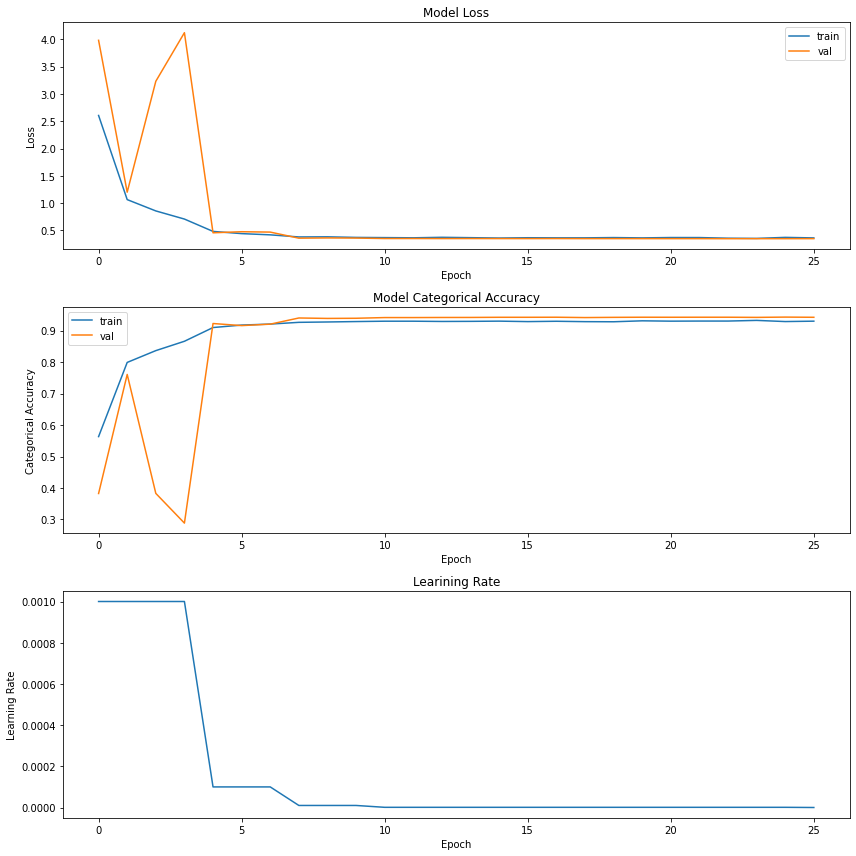

In [10]:
fig = plt.figure(figsize=(12,12), tight_layout=True)

plt.subplot(311)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(312)
plt.plot(hist.history['sparse_categorical_accuracy'])
plt.plot(hist.history['val_sparse_categorical_accuracy'])
plt.title('Model Categorical Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(313)
plt.plot(hist.history['lr'])
plt.title('Learining Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')

if(RUN_WANDB):
    run.log({'train_graph': wandb.Image(fig, caption="Training Graph")})
plt.show()

### **Analyze Results on the Test Set**

In [11]:
ev = model.evaluate((X_test,y_test),y_test)
if(RUN_WANDB):
    run.log({'test/loss':ev[0]})
ev

313/313 [==============================] - 5s 15ms/step - loss: 0.3384 - sparse_categorical_accuracy: 0.9405 - sparse_top_k_categorical_accuracy: 0.9900


[0.338431179523468, 0.940500020980835, 0.9900000691413879]

## **Clustering Embeddings Analysis**

Here we will use kmeans to create clusters of the embeddings. Since we know the number of labels we will use this as our K-value (this is the number of clusters). We then go through each cluster and find the dominant label in this cluster. We make the assumption here that the network performed half decent and that most samples are correctly labelled. For the purposes of this project, which is to show off the effectiveness of different clustering techniques, this works fine. For different projects it would be advisable to not make this assumption, maybe classifying samples with a K-Nearest Neighbors classifier based on the labelled training data.

Cluster accuracy represents the fraction of samples that are in the correct cluster, or in other words the number of samples that are found in the cluster with a matching dominant label. We can then create a confusion matrix showing the actual and predicted class probabilities.

In [12]:
def kmeans_cluster_accuracy(embeddings, y):
    # run k-means
    all_labels = labels_df['label'].values
    kmeans = KMeans(n_clusters=len(all_labels), random_state=123)
    labels = kmeans.fit_predict(embeddings)
    
    # find the mapping of each kmeans label to the actual label
    label_mappings = {}
    for label in all_labels:
        values, counts = np.unique(y[np.where(labels==label)], return_counts=True)
        label_mappings[label] = values[np.argmax(counts)]
    
    # map kmeans labels to actual label
    map_labels = np.vectorize(lambda x: label_mappings[x])
    mapped_labels = map_labels(labels)
    
    # calculate the centers for each mapped labels
    kmeans_clusters = kmeans.cluster_centers_
    mapped_clusters = {}
    for label in all_labels:
        mapped_clusters[label_mappings[label]] = kmeans_clusters[label,:]
    return accuracy_score(y.reshape((-1,1)), mapped_labels.reshape((-1,1))), mapped_labels, mapped_clusters

embeddings = body.predict(X_test)
accuracy, preds, cluster_centers = kmeans_cluster_accuracy(embeddings, y_test)
# run.log({'test/clustering_accuracy':accuracy})
print(f"Cluster Accurancy {accuracy}")

 25/313 [=>............................] - ETA: 1s

2022-12-20 21:53:48.492490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step
Cluster Accurancy 0.9606


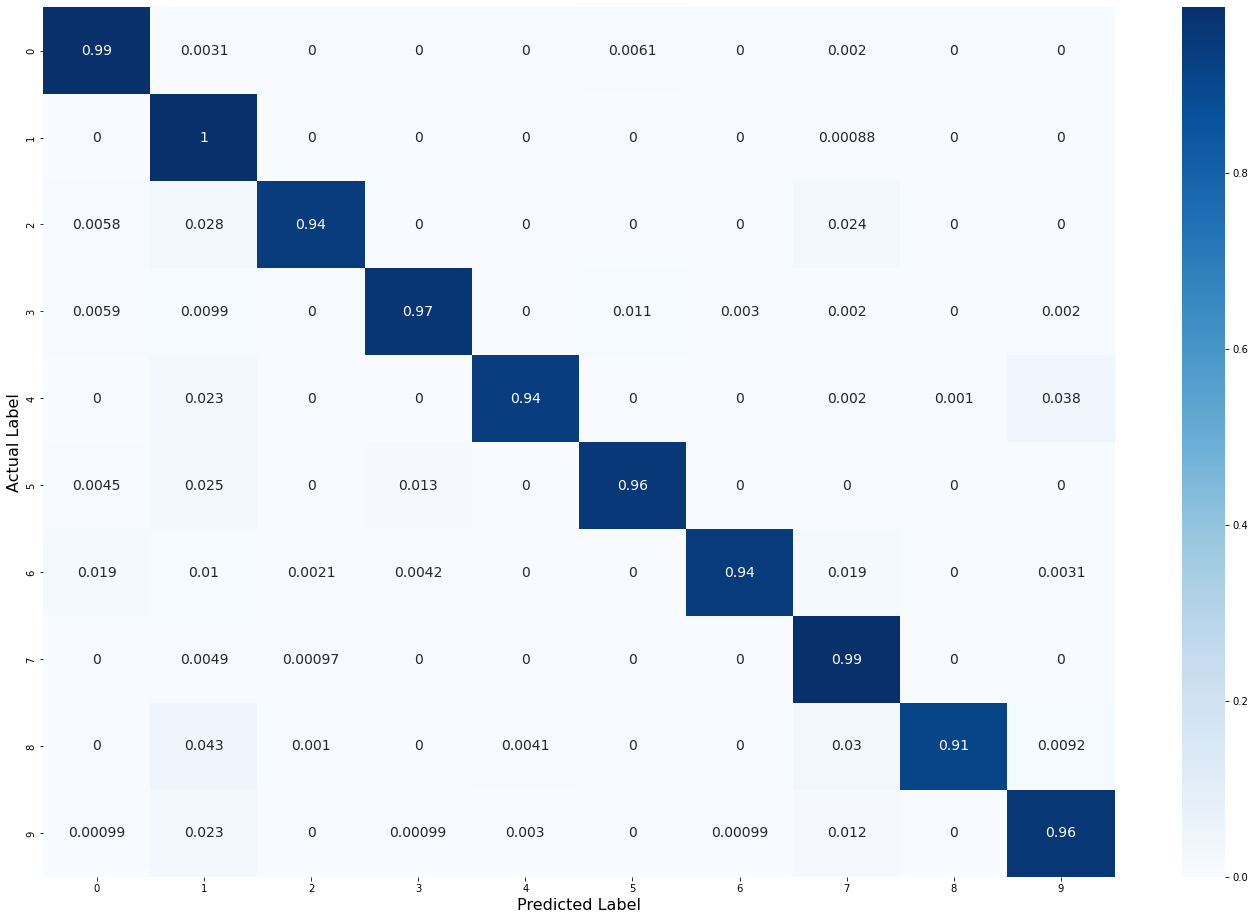

In [13]:
cf = confusion_matrix(y_test, preds, normalize='true')
class_names = labels_df['name'].values
fig, ax = plt.subplots(1,1,figsize=(24,16))
sns.heatmap(cf, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Blues', robust=True, ax=ax, annot_kws={"size": 14})
ax.set_ylabel("Actual Label", fontdict={'fontsize':16})
ax.set_xlabel("Predicted Label", fontdict={'fontsize':16})
if(RUN_WANDB):
    run.log({'confusion_matrix': wandb.Image(fig, caption="Confusion Matrix")})
plt.show()

In [14]:
if(RUN_WANDB):
    run.log({
        "testExamples": [wandb.Image(im, caption=f"Pred:{pred} Lable:{y}")
                            for im, pred, y in zip(X_test[:16,:,:,:], np.argmax(preds[:16], axis=-1), y_test[:16])]
    })

## **Volume Of Embeddings Space**

First we will get the volume of the overall embeddings space. This will help us get a baseline for the total space that was learned here. This will make it easier to compare embeddings later on.

In [15]:
from scipy.spatial import ConvexHull
hull = ConvexHull(embeddings)
overall_volume = hull.volume
overall_volume

54.767586011317434

## **Collect Cluster Info And Plot Mahalanbois Distance**

Here we calculated the covariance matrix for the different clusters. This will let us calculate the Mahalanbois distance for the positive and negative points in the cluster. Since our embeddings space is not 1-dimensional our clusters are not 1-dimensional either. Since our clusters may vary differently on the different basis vectors a simple euclidean distance might not make sense. Picture an oval with semi-axis 10 on the x-axis and 5 on the y-axis. A point 10 units away on the x-axis is closer to the mass of the oval than a point 10 units away on the y-axis. This is where Mahalanbois distance comes in. This gives us the covariance adjusted distance from the cluster. Letting us easily compare the true positives and false positives classification within a cluster.


#### **Calculating the Volume of a Cluster**
The next thing we do is we also calculate the volume of the embeddings for the cluster. This is done in two ways. The first is simple and we get the volume of all points in the cluster. This is fine but a thing to note is that there will always be outlier points, and maybe we don't want to worry about those few outliers so much. Well we have a covariance matrix which tells us the covariance and the correlation between covariance in the different dimensions. 

We will start by thinking of the covariance matrix as some linear transformation from standard basis vecotrs. Now unless the correlation between the different dimensions is independent, meaning we have zeros for any cells off the diagonal of the covariance matrix, this linear transformation is throwing the basis vectors off their span making them uselss to calculate the volume of the ellipsoid. You can already probably guess that this is where the eigen vectors and eigen values come in. The eigenvectors will be the new basis vectors we consider as they aren't thrown off their span, and the eigen-values will be the scalling factor each of these basis vectors undergo. Since we want volume, and don't care so much about orientation we can just pretend we have an axis aligned error ellipsoid with the semi-axis being the square root (since variance is the squared standard deviation) of the eigen-values.

With the standard deviation in each direction, and new basis vectors that make the dimensions of our error ellisoid independent from one another, we can write the error ellipsoid like we would any standard axis-aligned ellipsoid like (x / sqrt(eigen-value-1))^2 + (y / sqrt(eigen-value-2))^2 + ... = S where is some scalling factor. This is handy becuase based on the covariance matrix we know the values of say x are normally distributed, we also subtracted the centroid when calculating this so the mean of this distribution is zero. Since we are dividing by the sqrt of the eigen value, this is the same thing as dividing by the standard deviation, which gives us a standard normal random vairable. 

Becuase we take the square of this standard normal random variable and add them together this is the difinition of a chi-squared distribution. Since the degrees of freedom is just the number of dimensions, we can use the lookup table to find the chi-squared critical value for n degrees of freedom and a 95% confidence level. 

A question I had myself was why this equation works for different sizes of error ellipsoids, the reason is that we have standardized normal random variables, we are accounting for the size of the independent random normal variables. This is why the scalling factor from the chi-squared distribution is the same for a given degrees of freedom and confidence level. I find it cool how all these things relate together.

At this point you may or may not be reading this explanation, I don't blame you either way. The fact you're reading this part means you're still with me so here we go. We have this cool formula but now how do we get the semi-axis lengths? Well this is the easy part, essentially we want the semi-axis lengths when all other semi-axis are zero. In other words the axis aligned ellipse semi-axis length on the x dimension is the length when the length on the y dimension is 0. Essentially the formula looks like this semi-axis-length = sqrt(S) * sqrt(eigen-value). Pretty simple right?

https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/

https://cookierobotics.com/007/

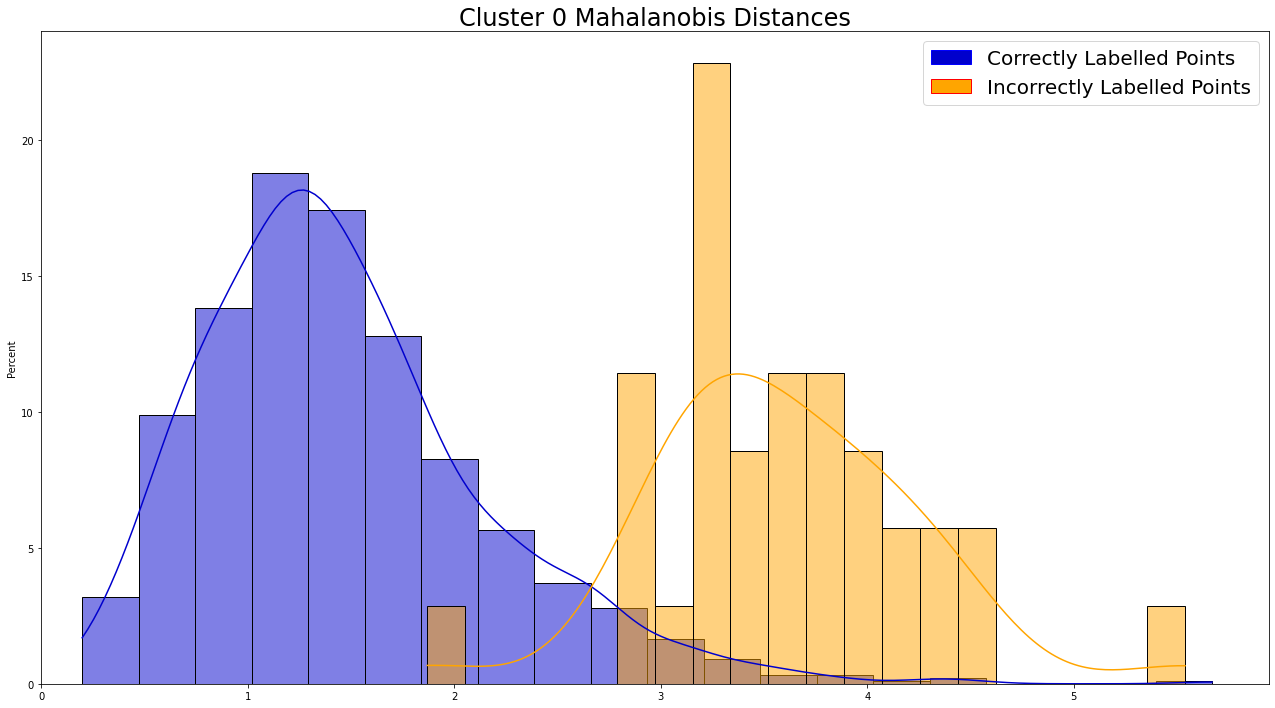

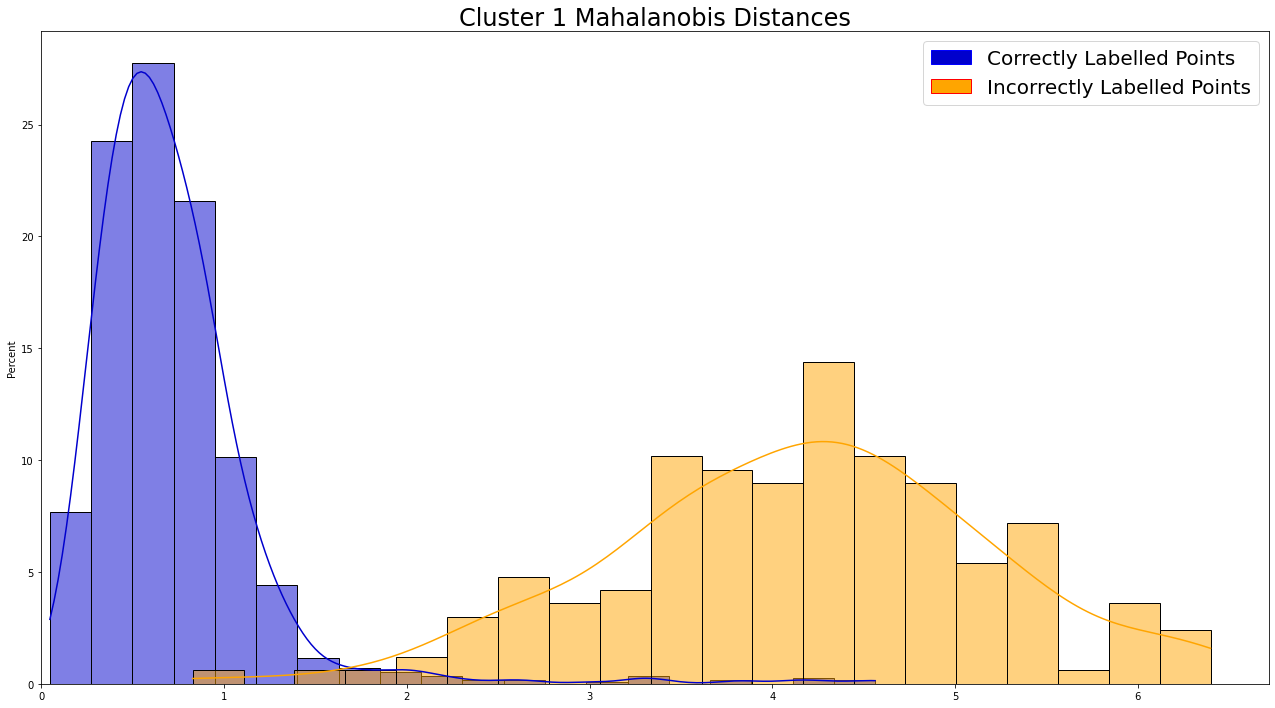

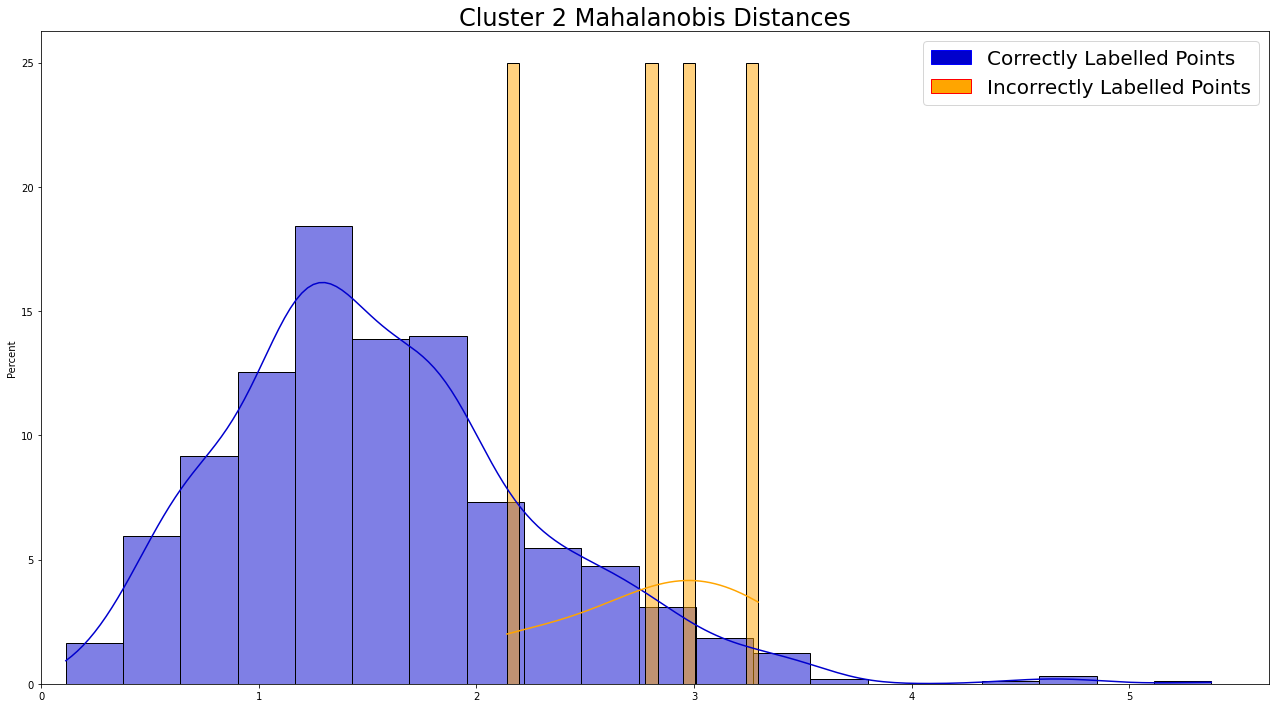

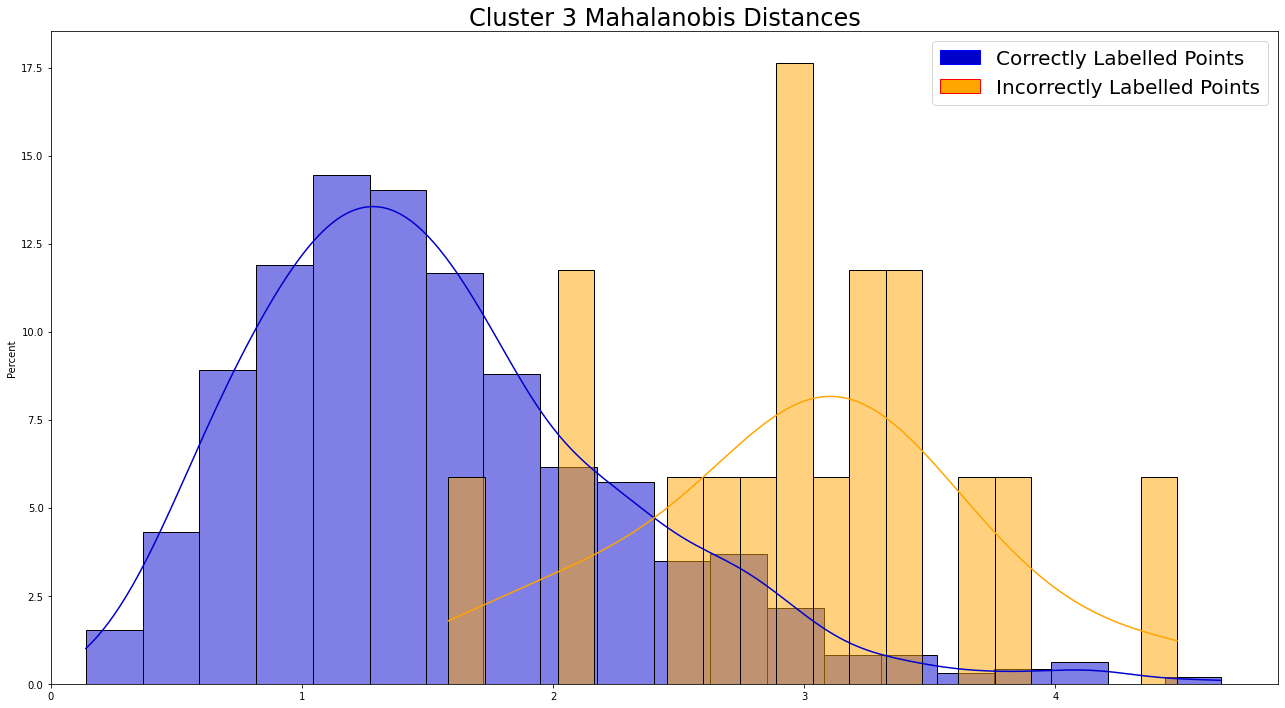

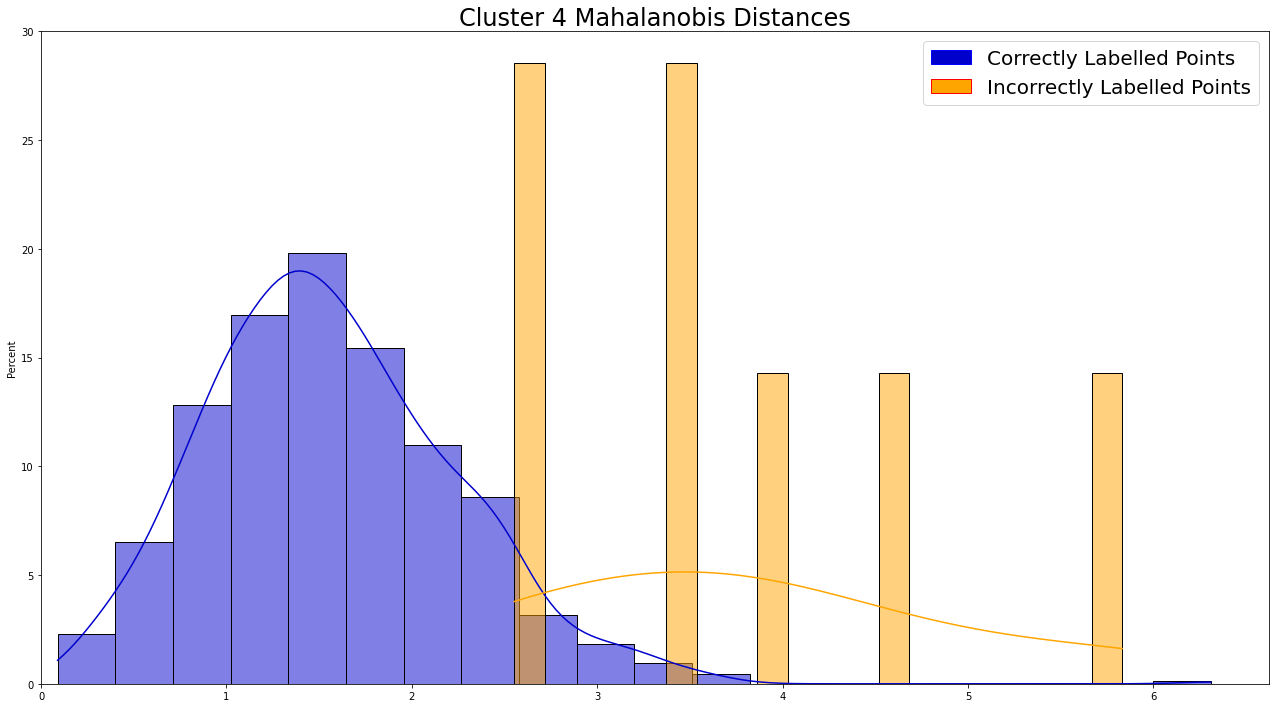

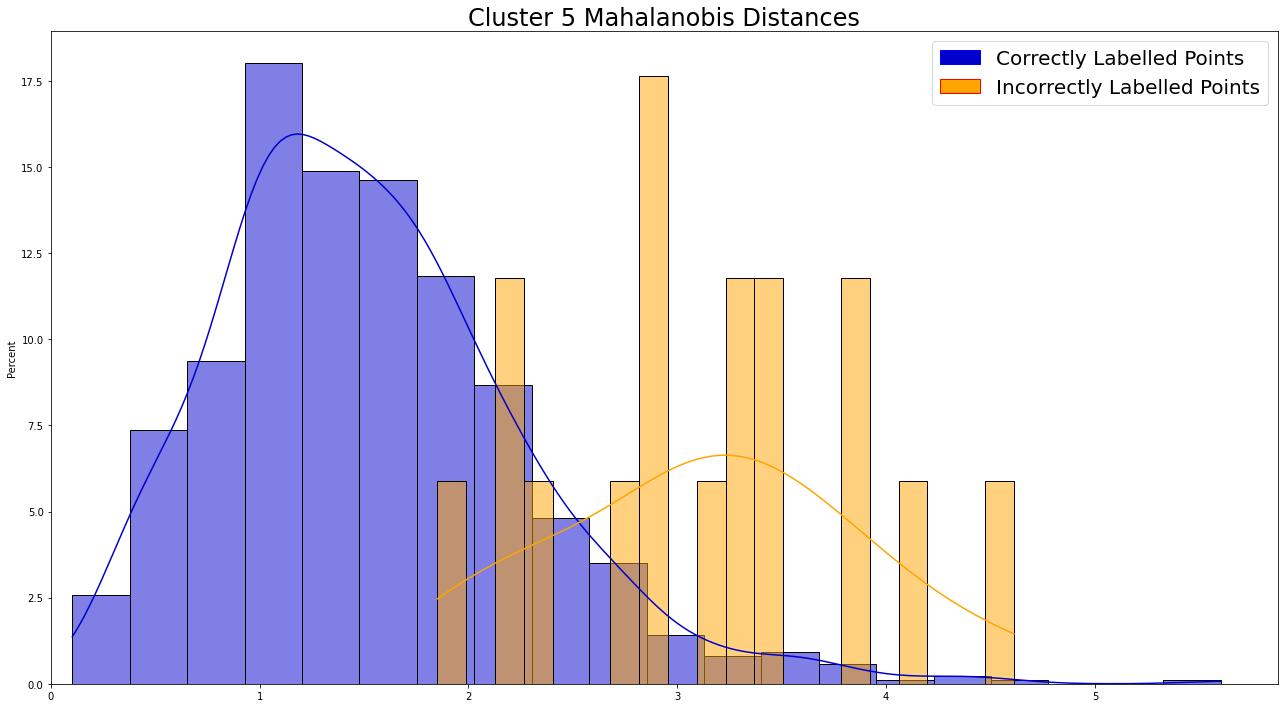

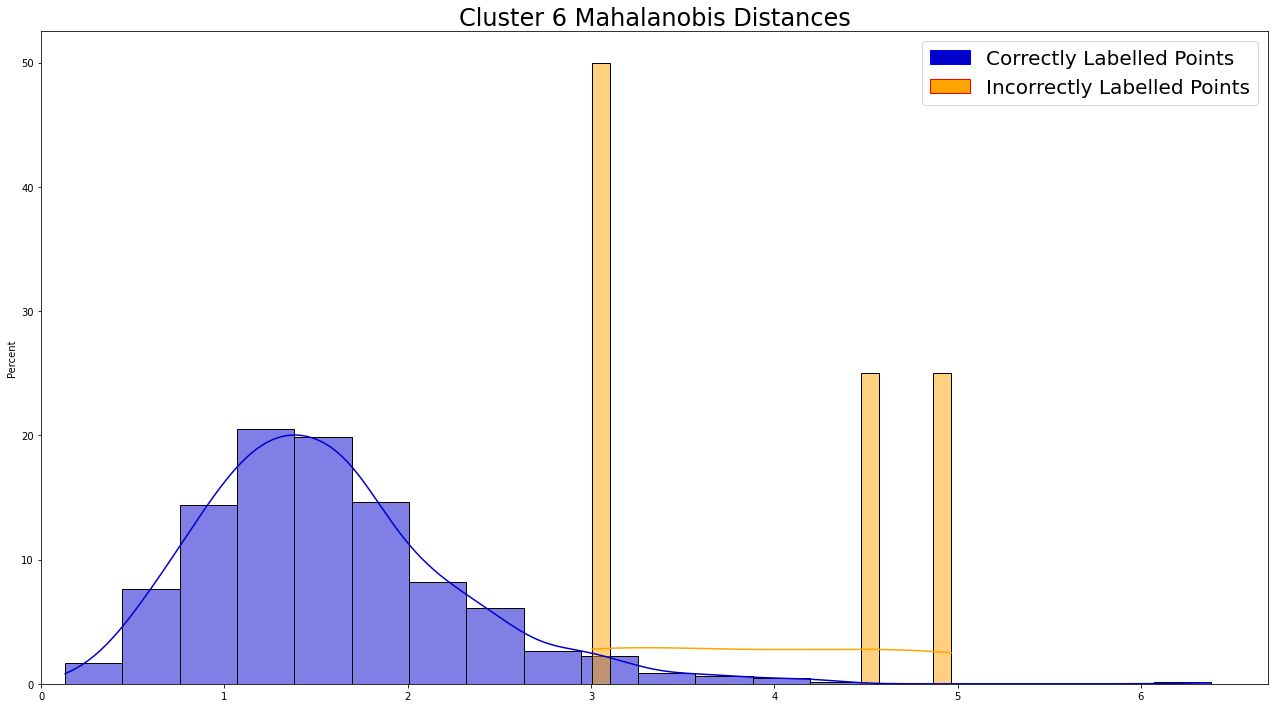

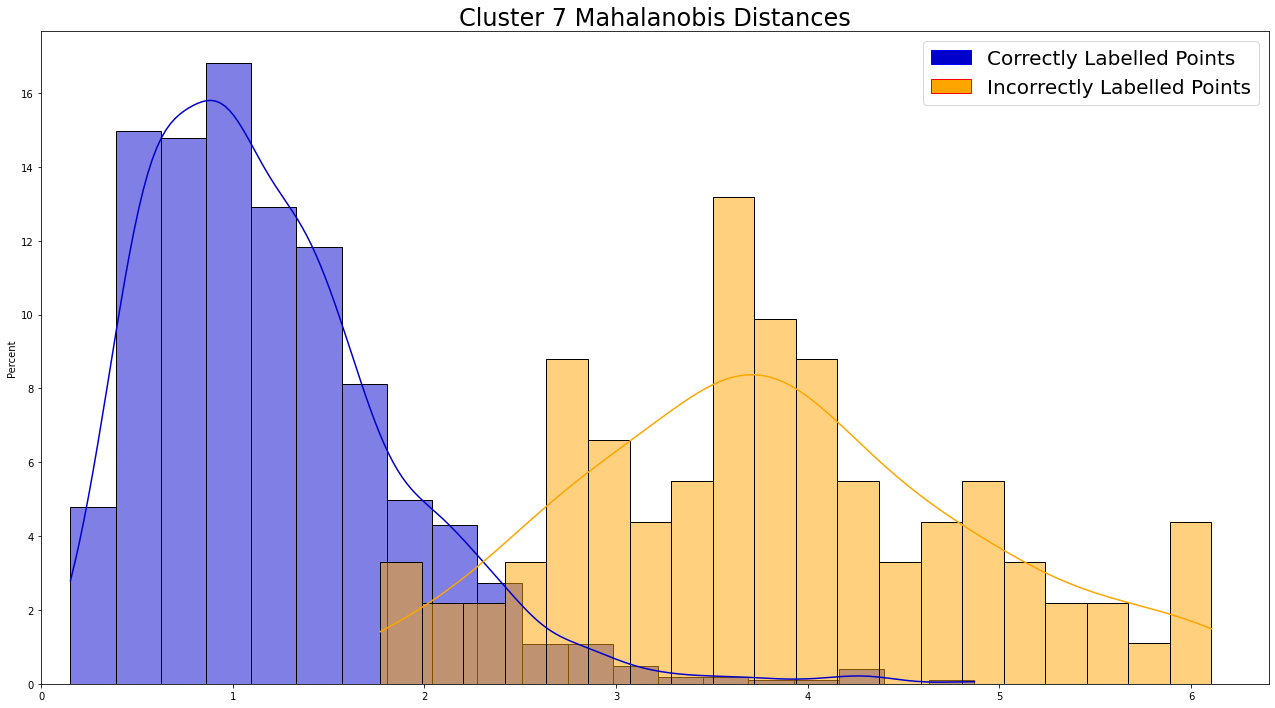

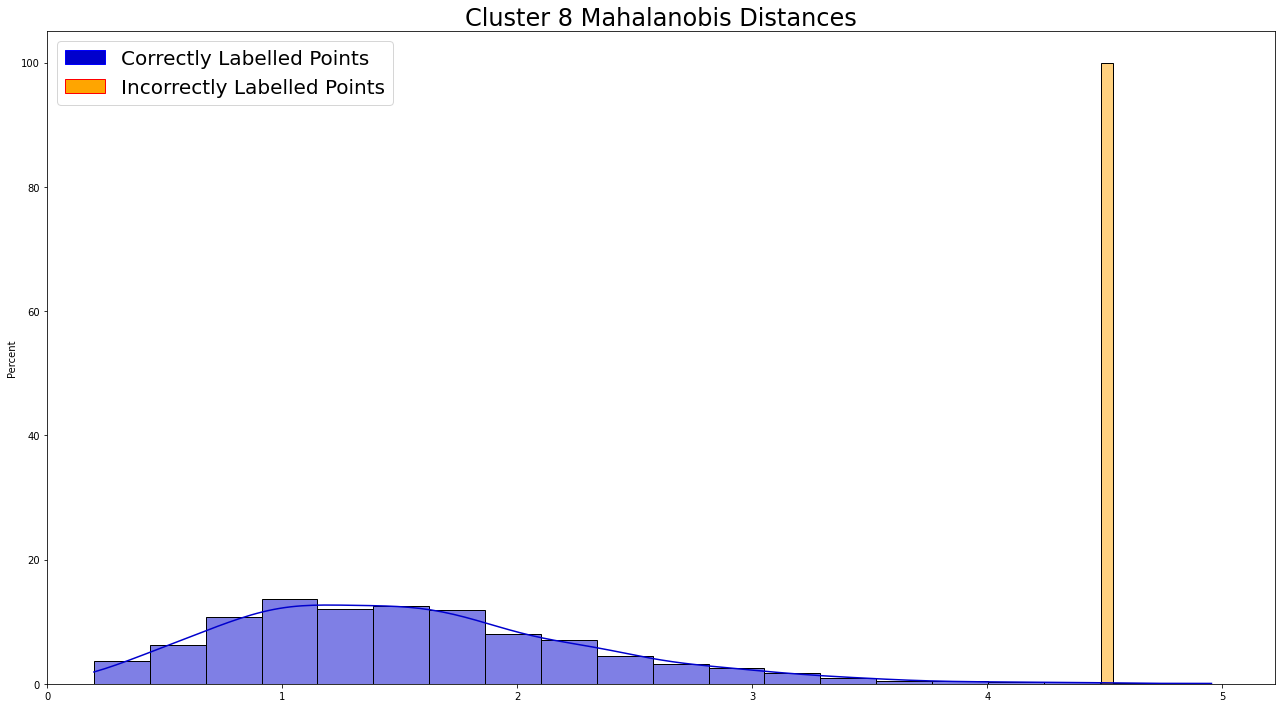

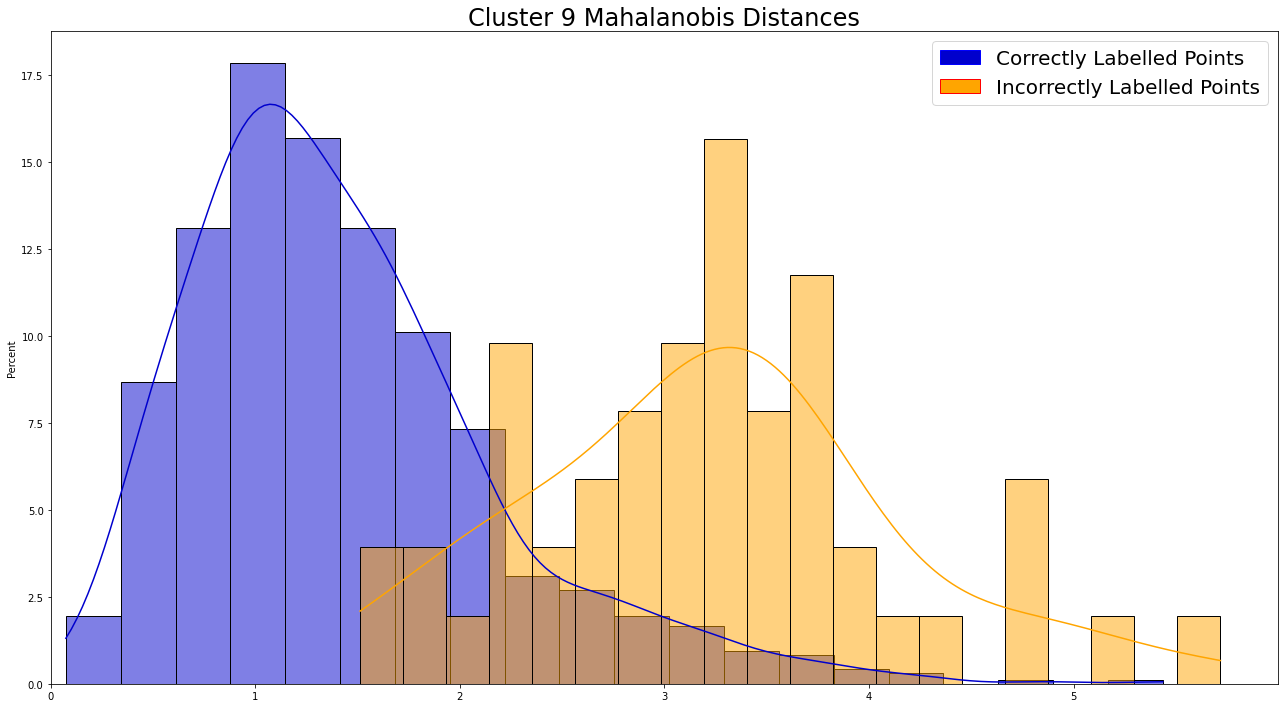

In [16]:
PLOT = True

def get_conf_interval(distances, indecies=None):
    if(indecies is not None):
        distances = distances[indecies]
    conf_interval = [np.min(distances),]
    for inter in [2,5,25,75,95,98]:
        conf_interval.append(np.percentile(distances,inter))
    conf_interval.append(np.max(distances))
    return conf_interval

def cosine_similarity(samples, point):
    samples = samples / np.linalg.norm(samples, axis=-1).reshape(-1,1)
    point = point / np.linalg.norm(point)
    cosine = samples @ point
    cosine = np.clip(cosine, -1.0, 1.0)
    theta = np.arccos(cosine)
    return theta
    
cluster_info = {}
for cluster in labels_df['label'].values:
    # pull the data we work with for this cluster
    indecies = np.where(preds==cluster)[0]
    samples = embeddings[indecies]
    actuals = y_test[indecies]
    centroid = cluster_centers[cluster]

    # grab the indecies of both positive and negative elements in the cluster
    positive_indecies = np.where(actuals==cluster)[0]
    negative_indecies = np.where(actuals!=cluster)[0]
    
    # calculate the covariance matrix of all samples
    cov = np.cov((samples - centroid).T)
    inv_cov = np.linalg.inv(cov)
    
    # calculate sample distances
    sample_mahalanbois_distances = np.array([mahalanobis(centroid, samples[idx,:], inv_cov) for idx in range(samples.shape[0])])
    sample_theta_distances = cosine_similarity(samples, centroid)
    
    # calculate the confidence interval for point densities
    conf_interval_mahalanobis = get_conf_interval(sample_mahalanbois_distances)
    conf_interval_theta = get_conf_interval(sample_theta_distances)
    
    # calculate the volume of the covariance matrix
    hull = ConvexHull(samples)
    volume = hull.volume
    
    eigen_values, eigen_vectors = np.linalg.eig(cov)
    if(config["EMBEDDING_SIZE"]==3):
        get_side_length = np.vectorize(lambda x: np.sqrt(7.815*x))
        semi_axes_lengths = get_side_length(eigen_values)
        confidence_volume = (4 / 3) * np.pi * semi_axes_lengths[0] * semi_axes_lengths[1] * semi_axes_lengths[2]
    elif(config["EMBEDDING_SIZE"]==2):
        get_side_length = np.vectorize(lambda x: np.sqrt(5.991*x))
        semi_axes_lengths = get_side_length(eigen_values)
        confidence_volume = np.pi * semi_axes_lengths[0] * semi_axes_lengths[1]
    else: 
        raise Exception(f'Invalid dimensions {len(semi_axes_lengths)}')
    
    # record the cluster information
    cluster_info[cluster] = {
        'cov':cov,
        'inv_cov':inv_cov,
        'conf_interval_mahalanobis':conf_interval_mahalanobis,
        'conf_interval_theta':conf_interval_theta,
        'positive_examples':len(positive_indecies),
        'negative_examples':len(negative_indecies),
        'volume':volume,
        'confidence_volume':confidence_volume,
    }
    
    if(PLOT):
        # plot the distances
        fig, ax = plt.subplots(1,1,figsize=(22,12))
        ax.set_title(f'Cluster {cluster} Mahalanobis Distances', fontsize=24)
        # create the dataframe to show or properly label the plots
        g1 = sns.histplot(data=sample_mahalanbois_distances[positive_indecies], stat='percent', color='mediumblue', kde=True, ax=ax, bins=20)
        g2 = sns.histplot(data=sample_mahalanbois_distances[negative_indecies], stat='percent', color='orange', kde=True, ax=ax, bins=20)
        # update the labels for the legend
        legend_elements = [
            Patch(facecolor='mediumblue',edgecolor='blue',label='Correctly Labelled Points'),
            Patch(facecolor='orange',edgecolor='red',label='Incorrectly Labelled Points'),
        ]
        plt.legend(handles=legend_elements, loc='best', fontsize=20)
        ax.set_xlim(left=-0.001)
        plt.show()
        print("")

### **Collect Cluster-to-Cluster Analysis Information**

Here we want to get some information about the other clusters. There are a lot of statistics that are calculated and not used such as all the confidence intervals on distances. I left the code here as some ideas for more ways to dive into the results. 

In [17]:
cluster_to_cluster = {}
for cluster in labels_df['label'].values:
    # pull the data we work with for this cluster
    indecies = np.where(preds==cluster)[0]
    samples = embeddings[indecies]
    actuals = y_test[indecies]
    centroid = cluster_centers[cluster]
    
    # iterate over other clusters to see how these points stack up on them
    for compare_cluster in labels_df['label'].values:
        if(cluster == compare_cluster):
            continue
            
        # get the cluster we will compare against
        comparative_centroid = cluster_centers[compare_cluster]
        
        # get the distance between the comparative centroid and this one
        centroid_distance_mahalanbois = mahalanobis(centroid, comparative_centroid, cluster_info[cluster]['inv_cov'])
        centroid_distance_theta = cosine_similarity(centroid.reshape(1,-1), comparative_centroid)
        
        # get the distance between points in this cluster
        sample_mahalanbois_distances = np.array([mahalanobis(comparative_centroid, samples[idx,:], cluster_info[compare_cluster]['inv_cov']) for idx in range(samples.shape[0])])
        sample_theta_distances = cosine_similarity(samples, comparative_centroid)
    
        # grab the indecies of both positive and negative elements in the cluster
        positive_indecies = np.where(actuals==compare_cluster)[0]
        negative_indecies = np.where(actuals!=compare_cluster)[0]
        
        # calculate the confidence interval for point densities
        conf_interval_mahalanobis = get_conf_interval(sample_mahalanbois_distances)
        conf_interval_theta = get_conf_interval(sample_theta_distances)
        
        # record what we learned
        d = cluster_to_cluster.get(compare_cluster, dict())
        d[cluster] = {
            'centroid_distance_mahalanbois':centroid_distance_mahalanbois,
            'centroid_distance_theta':centroid_distance_theta,
            'conf_interval_mahalanobis':conf_interval_mahalanobis,
            'conf_interval_theta':conf_interval_theta,
            'positive_samples':len(positive_indecies),
            'negative_samples':len(negative_indecies)
        }
        cluster_to_cluster[compare_cluster] = d

## **Display The Percent Of Volume That Each Cluster Takes Up**

Here we display the overall and 95% confidence level volumes that the clusters take up. This is a good way of showing how tight the clusters are compared to the space aloted. This is not a perfect measure but we can look at the differences between the overall and confidence level volumes. We might also be interested in the percent of the total volume that is covered by points. The tigher the clusters the lower the volume percent. This will be skewed if the overall volume is smaller, but using the 95% to total comparison we can get an idea for the ratio.

In [18]:
volumes = []
confidence_volumes = []
for cluster in cluster_info.keys():
    volume_ratio = (cluster_info[cluster]['volume'] / overall_volume) * 100
    confidence_volume_ratio = (cluster_info[cluster]['confidence_volume'] / overall_volume) * 100
    volumes.append(volume_ratio)
    confidence_volumes.append(confidence_volume_ratio)
    print(f"Cluster {cluster} => Volume Ratio: {volume_ratio:,.3f}% 95% Confidence Volume Ratio: {confidence_volume_ratio:,.3f}%")
    
print("")
print("Overall Statistics")
print(f"Mean Values   => Mean Volume Ratio: {np.mean(volumes):,.3f}% Mean 95% Confidence Volume Ratio: {np.mean(confidence_volumes):,.3f}%")
print(f"Summed Values => Total Volume Ratio: {np.sum(volumes):,.3f}% Total 95% Confidence Volume Ratio: {np.sum(confidence_volumes):,.3f}%")
print("")
print(f"Total Volume: {overall_volume:,.0f}")

Cluster 0 => Volume Ratio: 2.801% 95% Confidence Volume Ratio: 1.767%
Cluster 1 => Volume Ratio: 4.398% 95% Confidence Volume Ratio: 1.391%
Cluster 2 => Volume Ratio: 3.767% 95% Confidence Volume Ratio: 2.750%
Cluster 3 => Volume Ratio: 3.637% 95% Confidence Volume Ratio: 2.496%
Cluster 4 => Volume Ratio: 5.480% 95% Confidence Volume Ratio: 3.801%
Cluster 5 => Volume Ratio: 4.384% 95% Confidence Volume Ratio: 3.047%
Cluster 6 => Volume Ratio: 2.128% 95% Confidence Volume Ratio: 1.595%
Cluster 7 => Volume Ratio: 3.794% 95% Confidence Volume Ratio: 1.940%
Cluster 8 => Volume Ratio: 6.218% 95% Confidence Volume Ratio: 5.057%
Cluster 9 => Volume Ratio: 4.284% 95% Confidence Volume Ratio: 2.585%

Overall Statistics
Mean Values   => Mean Volume Ratio: 4.089% Mean 95% Confidence Volume Ratio: 2.643%
Summed Values => Total Volume Ratio: 40.891% Total 95% Confidence Volume Ratio: 26.428%

Total Volume: 55


## **Visualize The Angles Between Points And Clusters**

Here is the important visualization. For each cluster we find the nearest cluster (given the angular distance between centroids) and we plot the angle between the points of the given cluster to the nearest cluster and vise-versa. This is one that is size agnostic, we can see the tighness of the clusters. The more centered the clusters the better the embeddings are. 

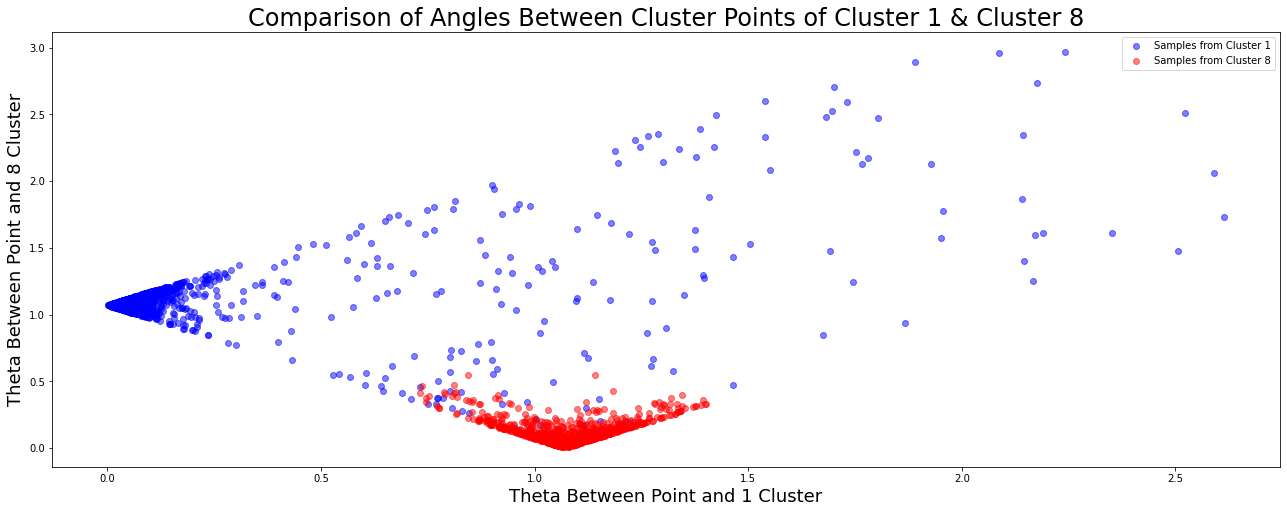

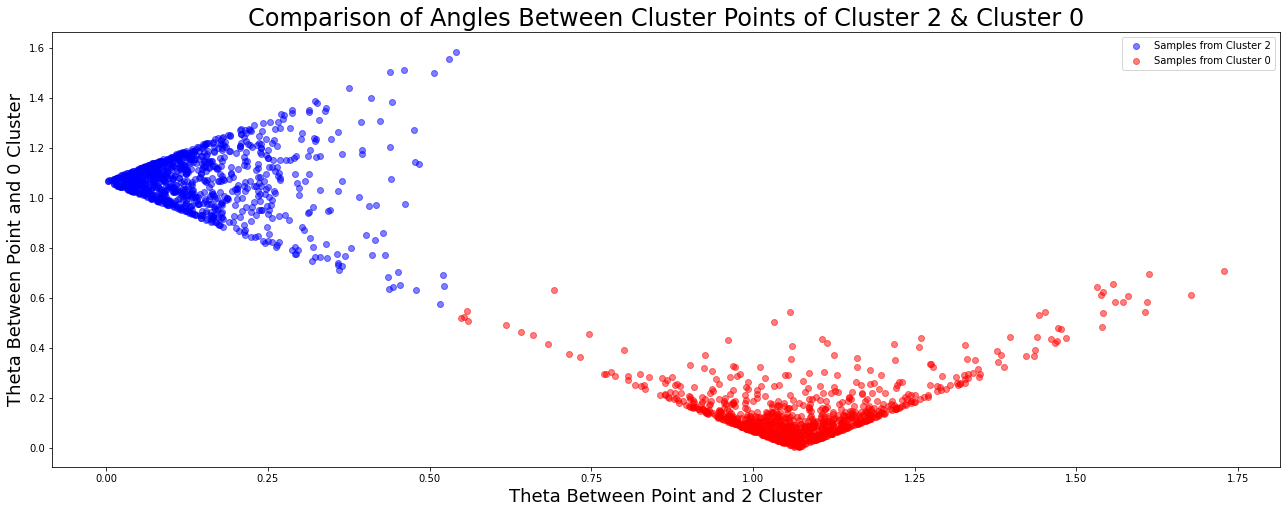

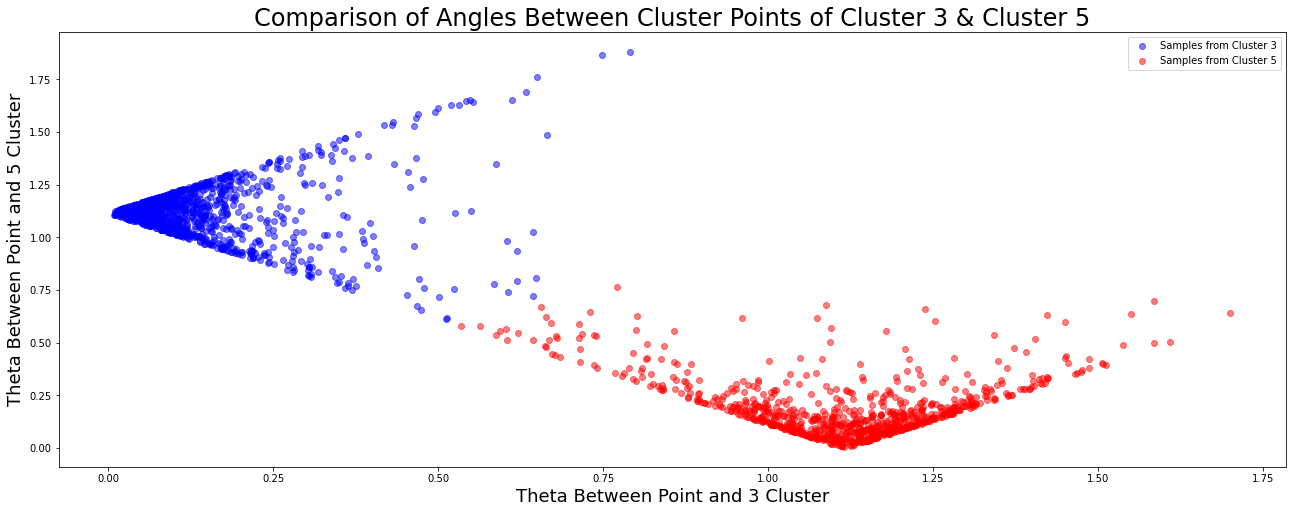

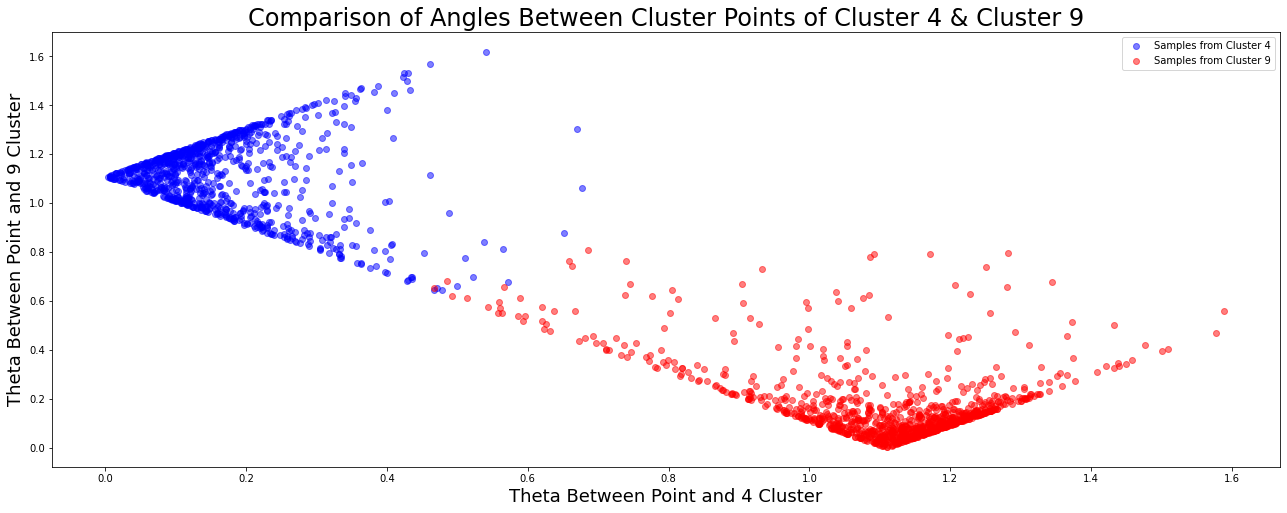

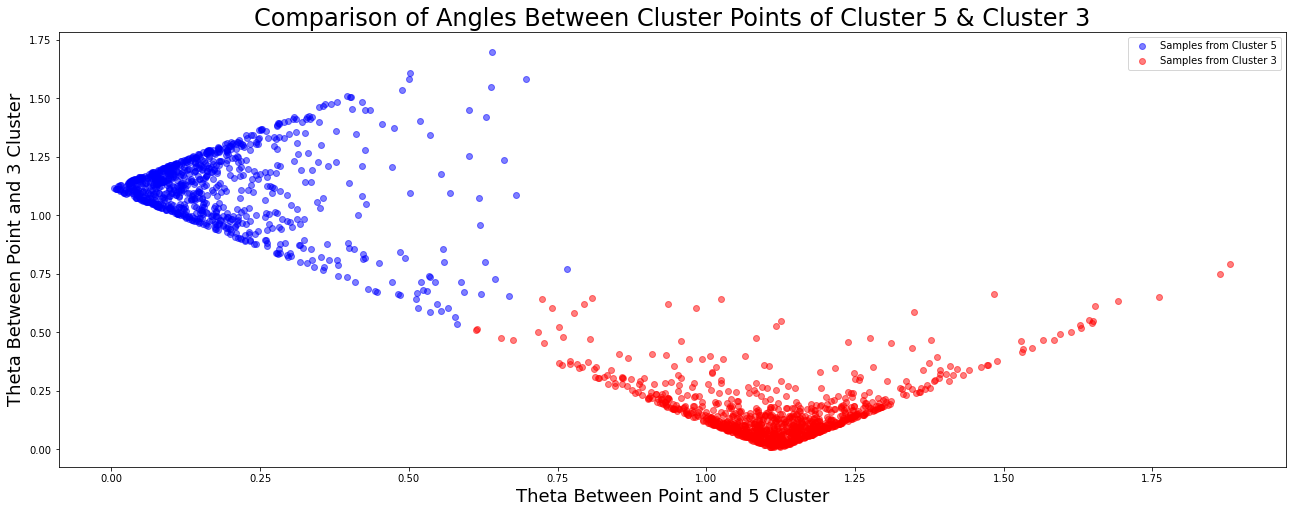

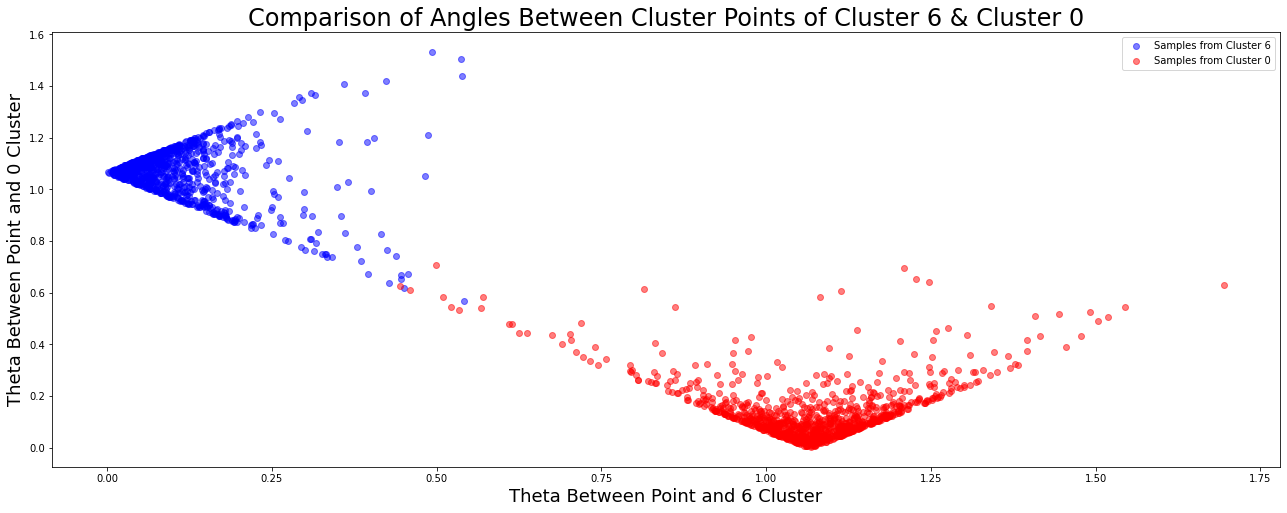

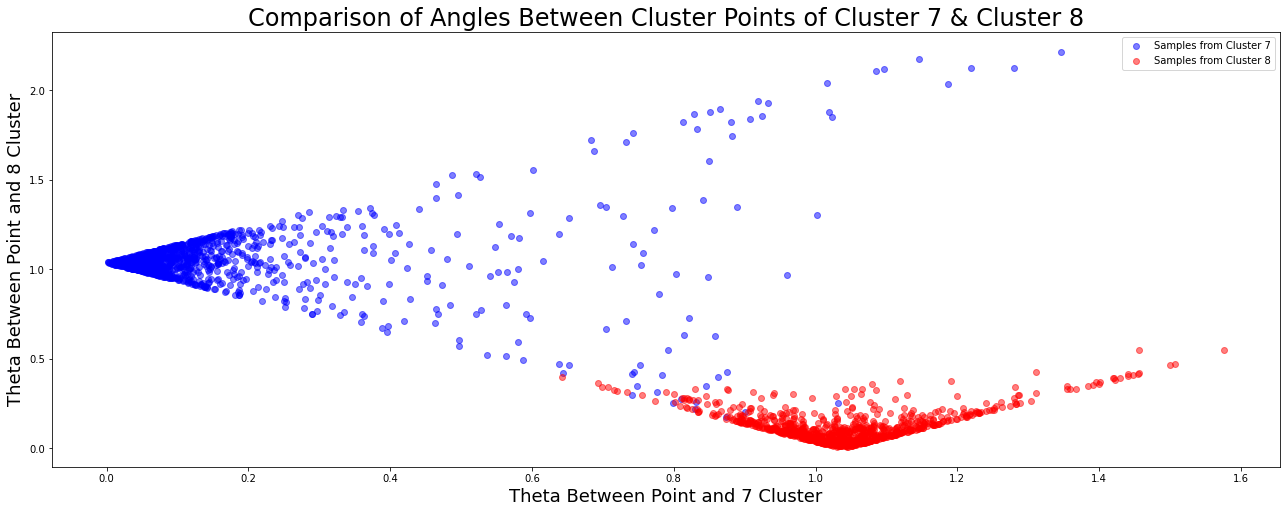

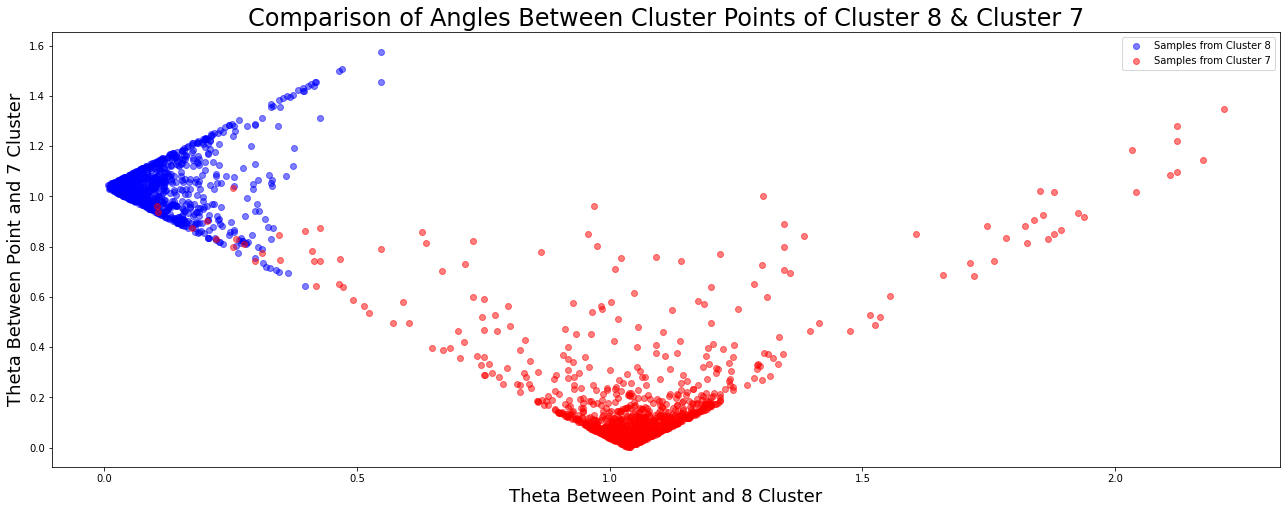

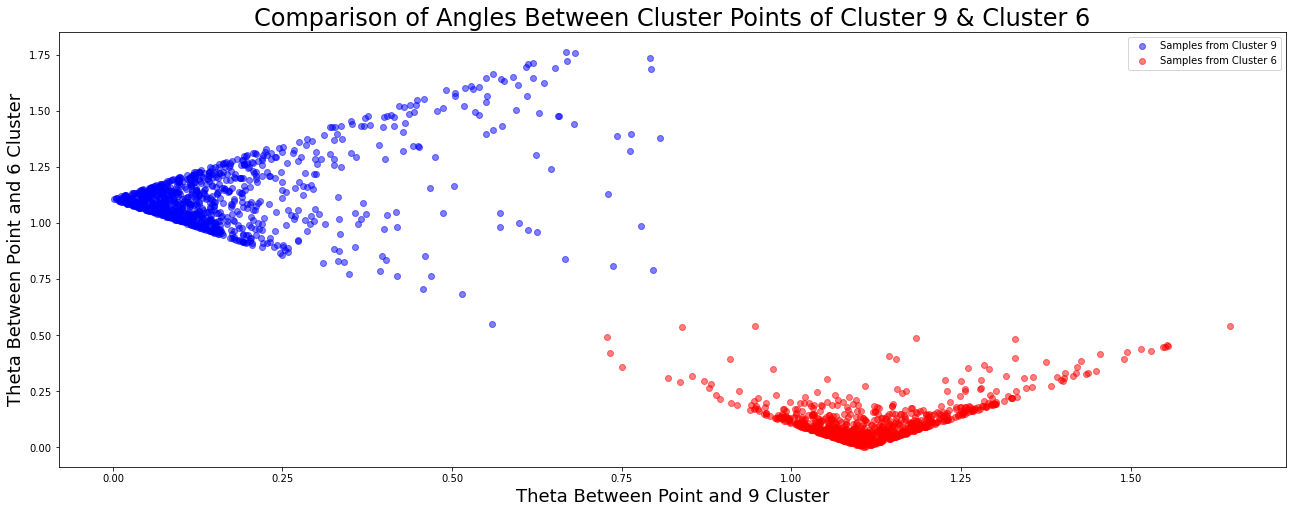

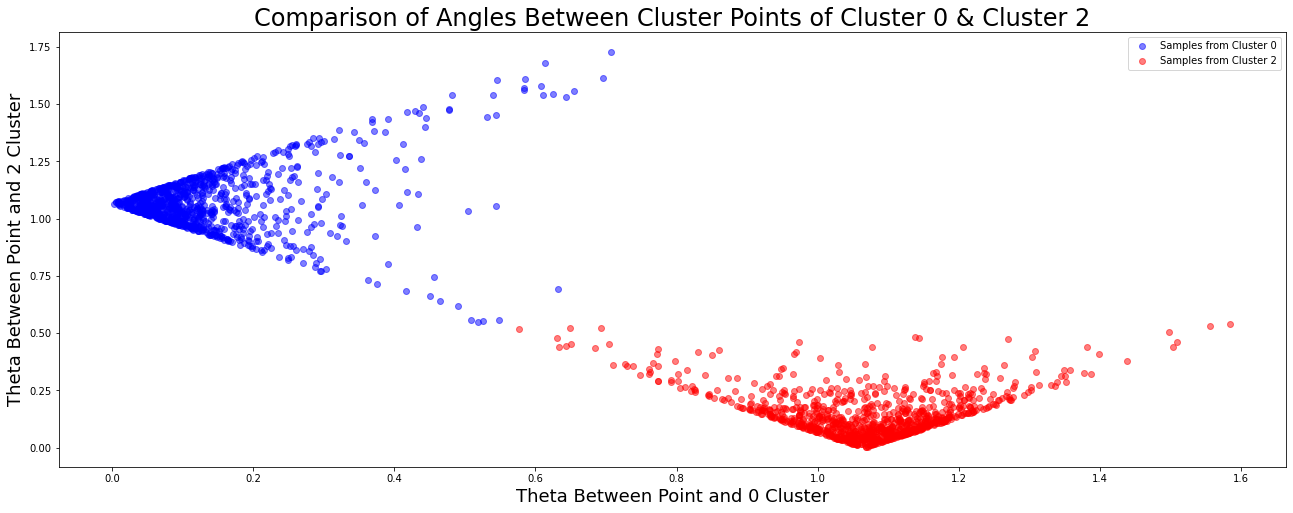

In [19]:
for cluster in cluster_to_cluster.keys():
    # get the samples
    indecies = np.where(preds==cluster)[0]
    samples = embeddings[indecies]
    # find the closest cluster to this one
    closest_cluster, distance = None, None
    for other_cluster in cluster_to_cluster[cluster].keys():
        if(distance is None or cluster_to_cluster[cluster][other_cluster]['centroid_distance_theta']<distance):
            closest_cluster = other_cluster
            distance = cluster_to_cluster[cluster][other_cluster]['centroid_distance_theta']
    # get the samples for the closest cluster
    closest_indecies = np.where(preds==closest_cluster)[0]
    closest_samples = embeddings[closest_indecies]
    # get the angular distances
    this_to_this_theta = cosine_similarity(samples, cluster_centers[cluster])
    this_to_other_theta = cosine_similarity(samples, cluster_centers[closest_cluster])
    other_to_this_theta = cosine_similarity(closest_samples, cluster_centers[cluster])
    other_to_other_theta = cosine_similarity(closest_samples, cluster_centers[closest_cluster])
    # plot the angular distance between points
    _, ax = plt.subplots(1,1,figsize=(22,8))
    ax.scatter(this_to_this_theta, this_to_other_theta, color='blue', label=f'Samples from Cluster {cluster}', alpha=0.5)
    ax.scatter(other_to_this_theta, other_to_other_theta, color='red', label=f'Samples from Cluster {closest_cluster}', alpha=0.5)
    ax.set_title(f'Comparison of Angles Between Cluster Points of Cluster {cluster} & Cluster {closest_cluster}', fontdict={'fontsize':24})
    ax.set_xlabel(f'Theta Between Point and {cluster} Cluster', fontsize=18)
    ax.set_ylabel(f'Theta Between Point and {closest_cluster} Cluster', fontsize=18)
    ax.legend(loc="best")
    plt.show()
    print("")

## **Visualize The Clustering Embeddings**

Here we try and see what the clustering looks like. I visualize this in both 2D and 3D. The reason for this is that TSNE is good at keeping items that are close in a higher dimension close in a lower one, but it isint always good when it comes to shapes and when comparing relative distances. What I mean by relative distances is say there is a point x on the edge of cluster A, the distance A -> x in TSNE cannot be directly compared to say the distance of point y on edge of cluster B since these distances can be manipulated in the transform.

A detailed TSNE Overview

https://distill.pub/2016/misread-tsne/

I found the code to make the very nice visualizations here

https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42#:~:text=t%2Ddistributed%20stochastic%20neighbour%20embedding,non%2Dlinear%20dimensionality%20reduction%20technique.


In [20]:
def visualize_embeddings_2d(embeddings, y):
    if(embeddings.shape[1] != 2):
        tsne = TSNE(n_components=2, learning_rate='auto', init='random', verbose=1, perplexity=50)
        embeddings = tsne.fit_transform(embeddings)
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(22,12))
    num_categories = 10
    for lab in range(num_categories):
        indices = y==lab
        ax.scatter(
            embeddings[indices,0],
            embeddings[indices,1], 
            c=np.array(cmap(lab)).reshape(1,4), 
            label=labels_df['name'].values[lab], 
            alpha=0.5
        )
    ax.legend(fontsize='large', markerscale=2)
    if(RUN_WANDB):
        run.log({'tsne_embeddings': wandb.Image(fig, caption="Test Embeddings")})
    plt.show()
    
def visualize_embeddings_3d(embeddings, y):
    if(embeddings.shape[1] != 3):
        tsne = TSNE(n_components=3, learning_rate='auto', init='random', verbose=1)
        embeddings = tsne.fit_transform(embeddings)
    cmap = cm.get_cmap('tab20')
    fig = plt.figure(figsize=(22,12))
    ax = fig.add_subplot(projection='3d')
    num_categories = 10
    for lab in range(num_categories):
        indices = y == lab
        ax.scatter(embeddings[indices, 0],
                   embeddings[indices, 1],
                   embeddings[indices, 2],
                   c=np.array(cmap(lab)).reshape(1, 4),
                   label=lab,
                   alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    if(RUN_WANDB):
        run.log({'tsne3d_embeddings': wandb.Image(fig, caption="Test Embeddings 3D")})
    plt.show()

embeddings = body.predict(X_test)

313/313 [==============================] - 1s 3ms/step


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.069784
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.276024
[t-SNE] KL divergence after 1000 iterations: 0.932947


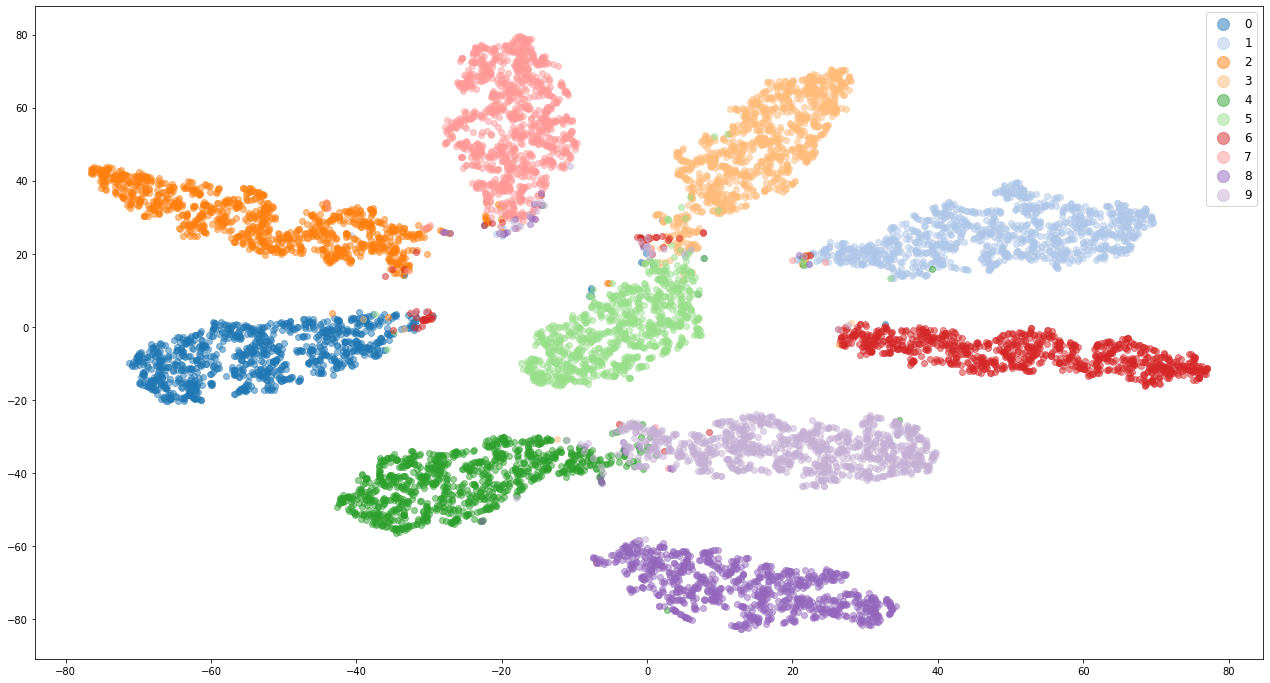

In [21]:
%matplotlib inline
visualize_embeddings_2d(embeddings, y_test)

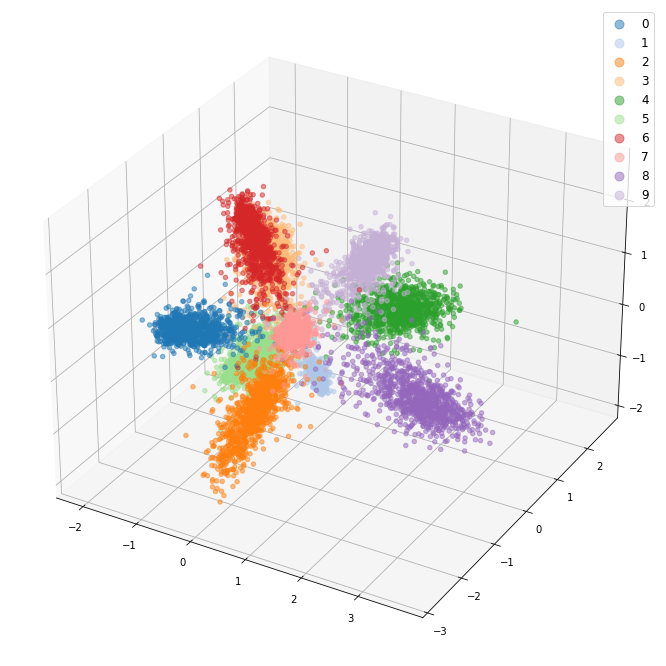

In [22]:
%matplotlib inline
visualize_embeddings_3d(embeddings, y_test)

## **Finish the Run and Upload the Results**

In [23]:
if(RUN_WANDB):
    run.finish()